In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

In [2]:
from irc.manager import IRCManager
from boxforage.utils import plot_single_box_episode

manager = IRCManager(defaults='irc_defaults/single_box.yaml')

# Train one agent for a single box environment

## Train an agent
We train a rational agent for the assume environment parameter $p_\mathrm{appear}=0.2, p_\mathrm{cue}=0.8, r_\mathrm{food}=10$.

The following can also be done by running `demo-train.py` in command line:
```bash
python demo-train.py env_param=[0.2,0.8,10] num_epochs=30
```

Checkpoint (epoch 60) loaded.
Agent (seed 100) was trained for 60 epochs, RL optimality 100.00%.


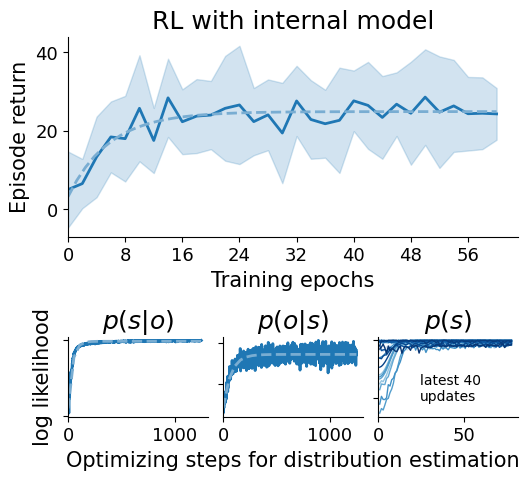

In [3]:
env_param = [0.2, 0.8, 10]
num_epochs = 30

seed = 100
agent = manager.train_agent(env_param, seed=seed, num_epochs=num_epochs)
agent, fig = manager.inspect_agent(env_param, seed=seed)

## Run the agent in an environment
We create another environment which has the same observation space and action space as the assumed one, albeit with a different set of environment parameters $(0.3, 0.6, 10)$.

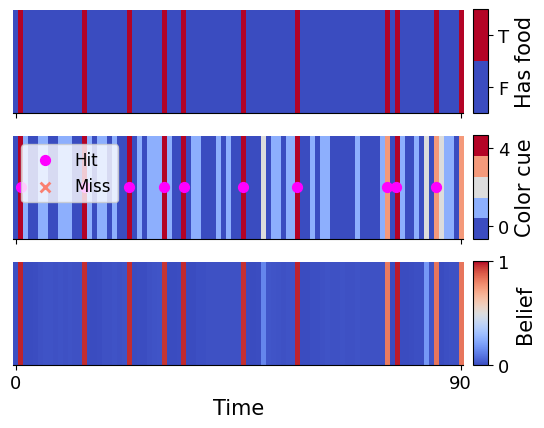

In [4]:
from boxforage.single_box import SingleBoxForaging

env = SingleBoxForaging(spec=manager.agent_manager.defaults.env.spec)
env.set_param([0.15, 0.9, 10.])

episode = agent.run_one_episode(env=env, num_steps=90)
fig = plot_single_box_episode(episode)

We can save the episode data in an external `pickle` file.

In [5]:
import os, pickle

episode_path = 'episode_12.pickle'

if os.path.exists(f'store/{episode_path}'):
    print(f"File store/{episode_path} already exists, will not be overwritten.")
else:
    agent_key = manager.agent_manager.configs.get_key(manager.agent_manager.config)
    trained_epoch = manager.agent_manager.stats[agent_key]['epoch']
    with open(f'store/{episode_path}', 'wb') as f:
        pickle.dump({
            'agent_key': agent_key, 'trained_epoch': trained_epoch,
            'external_env_param': env.get_param(),
            'internal_env_param': agent.model.env.get_param(),
            **episode,
        }, f)
    print(f"Episode data saved at '{episode_path}'.")

File store/episode_12.pickle already exists, will not be overwritten.


# Train multiple agents for different environments

## Sweep over parameter grid

We define a grid of environment parameters, and train multiple agents for each of the combination using different random seeds.

The following can also be done by running `demo-sweep.py` in command line:
```bash
python demo-sweep.py num_epochs=10 count=5
```

In [6]:
# with open('param_grids/single_box.yaml', 'r') as f:
#     env_param_grid = yaml.safe_load(f)
env_param_grid = [
    [0.05, 0.1, 0.15, 0.2, 0.25], # p_appear
    [0.6, 0.7, 0.8, 0.9], # p_cue
    [2., 5., 10.], # r_food
]
agent_seeds = list(range(10))

num_epochs = 10 # number of RL epochs
count = 5 # number of agents to be trained

manager.train_agents(env_param_grid=env_param_grid, seeds=agent_seeds, num_epochs=num_epochs, count=count)

0 works processed.
All works are processed or being processed.


In [7]:
report = manager.overview_agents(env_param_grid=env_param_grid, seeds=agent_seeds, min_epoch=30)

Average progress of training 100.0% (30 epochs as complete).
Approximate training time 33m35.88s per epoch.
Approximate evaluation time 3m54.36s.
Average training optimality 99.6%


# Compute likelihood of an episode

## Likelihood of a specific agent

Given a sequence actions and observations, we compute the likelihood of episode data conditioned on the agent that generates it.

In [8]:
logp = agent.episode_likelihood(episode['actions'], episode['observations'])
print('log likelihood {:.3f}'.format(logp))

log likelihood -0.104


## Likelihood of a series of agents

After multiple agents have been trained on a grid of environment parameters, compute the likelihood of episode data conditioned on each agent.

External environment parameter: (0.15, 0.6, 10.0)
Length of episode: 60
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 878701 (60 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


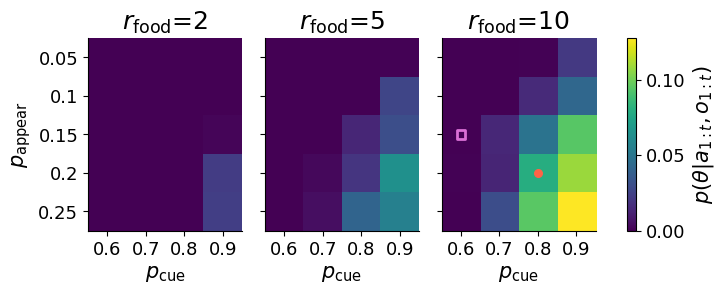

External environment parameter: (0.15, 0.9, 10.0)
Length of episode: 60
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 1C2CED (60 time steps)...
0 works processed.
All works are processed or being processed.
96.15% of the likelihood entries have been computed.


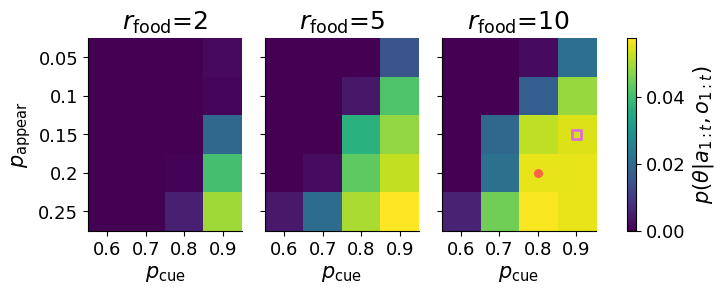

External environment parameter: (0.25, 0.6, 10.0)
Length of episode: 60
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 03BC0A (60 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


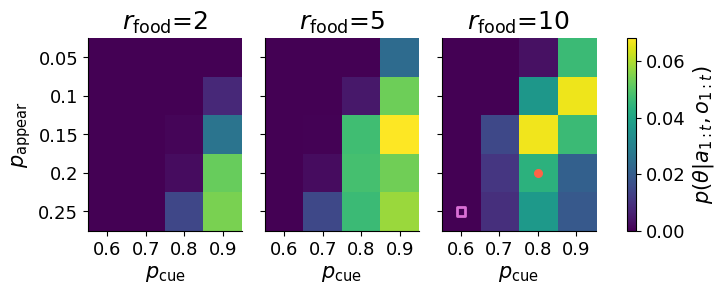

External environment parameter: (0.25, 0.9, 10.0)
Length of episode: 60
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 4B5F7F (60 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


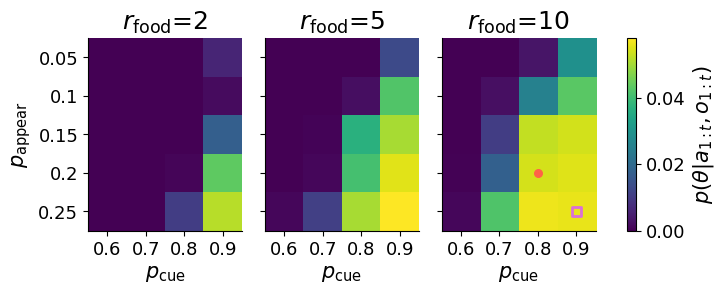

External environment parameter: (0.15, 0.6, 10.0)
Length of episode: 90
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 8570CC (90 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


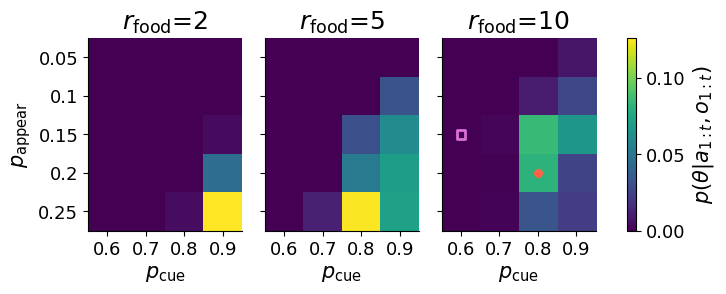

External environment parameter: (0.15, 0.9, 10.0)
Length of episode: 30
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 6C1D26 (30 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


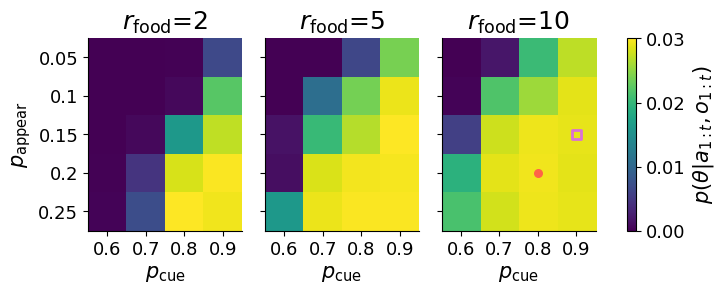

External environment parameter: (0.25, 0.6, 10.0)
Length of episode: 90
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 9D2E0E (90 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


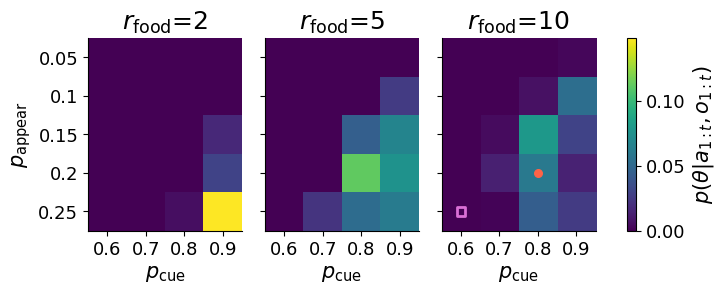

External environment parameter: (0.25, 0.6, 10.0)
Length of episode: 30
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 780E6B (30 time steps)...
0 works processed.
All works are processed or being processed.
96.17% of the likelihood entries have been computed.


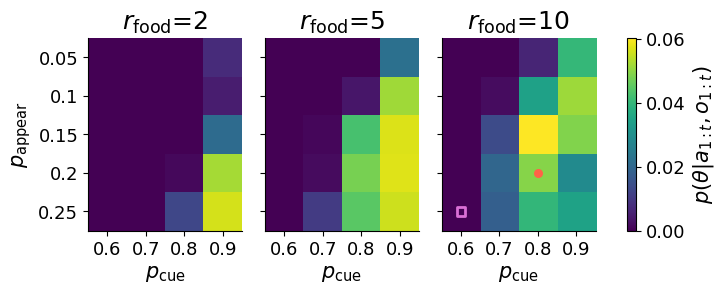

External environment parameter: (0.15, 0.9, 10.0)
Length of episode: 90
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
577 valid agents found.
Computing likelihood of episode 3CE495 (90 time steps)...
------------
Processing 57B1A4BB (1)...
Checkpoint loaded.
------------
Processing FC409190 (11)...
No checkpoint loaded.
Agent environment parameter:
(0.05, 0.7, 10.0)
Log likelihood of an agent (trained for 30 epochs): -54.671 (0m38.93s)
14 works processed.
All works are processed or being processed.
95.58% of the likelihood entries have been computed.


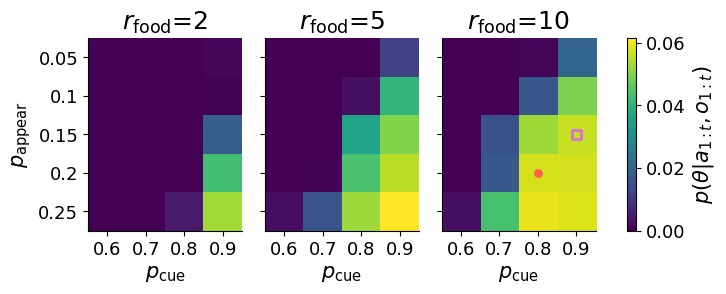

In [9]:
from irc.utils import logmeanexp

for episode_path in ['episode_{:02d}.pickle'.format(i) for i in range(4, 13)]:
    with open(f'store/{episode_path}', 'rb') as f:
        saved = pickle.load(f)
    print('External environment parameter: {}'.format(tuple(saved['external_env_param'])))
    print('Length of episode: {}'.format(saved['num_steps']))
    
    logps = manager.compute_logps(
        episode_path=episode_path, env_param_grid=env_param_grid,
        agent_seeds=agent_seeds, min_epoch=25, min_optimality=0.98, patience=0,
    )

    p = np.exp(logmeanexp(logps, axis=(-2, -1)))
    p /= np.nansum(p)

    _, axes = plt.subplots(1, p.shape[2], figsize=(8, 2.5), gridspec_kw={'wspace': 0.02})
    for i, ax in enumerate(axes):
        h = ax.imshow(p[..., i], vmin=0, vmax=np.nanmax(p))
        ax.set_title(r'$r_\mathrm{food}$'+'={:g}'.format(env_param_grid[2][i]))
        ax.set_xticks(range(p.shape[1]))
        ax.set_xticklabels(['{:g}'.format(v) for v in env_param_grid[1]])
        ax.set_xlabel(r'$p_\mathrm{cue}$')
        ax.set_yticks(range(p.shape[0]))
        if i==0:
            ax.set_yticklabels(['{:g}'.format(v) for v in env_param_grid[0]])
            ax.set_ylabel(r'$p_\mathrm{appear}$')
        else:
            ax.set_yticklabels([])
    # agent environment parameter
    with open(f'store/{episode_path}', 'rb') as f:
        saved = pickle.load(f)
    env_param = saved['internal_env_param']
    i = env_param_grid[0].index(env_param[0])
    j = env_param_grid[1].index(env_param[1])
    k = env_param_grid[2].index(env_param[2])
    axes[k].scatter(j, i, s=30, marker='o', color='tomato')
    env_param = saved['external_env_param']
    i = env_param_grid[0].index(env_param[0])
    j = env_param_grid[1].index(env_param[1])
    k = env_param_grid[2].index(env_param[2])
    axes[k].scatter(j, i, s=40, marker='s', edgecolor='orchid', facecolor='none', linewidth=2)
    plt.colorbar(h, ax=axes, label=r'$p(\theta|a_{1:t},o_{1:t})$', fraction=0.1)
    plt.show()